In [1]:
%matplotlib inline

Initialize an Astropy Table to store model galaxies

In [2]:
from astropy.table import Table

galaxies = Table()

num_halos = int(1e5)
galaxies['galid'] = np.arange(num_halos).astype(int)

Generate a Monte Carlo realization of host halo masses using a simple power law

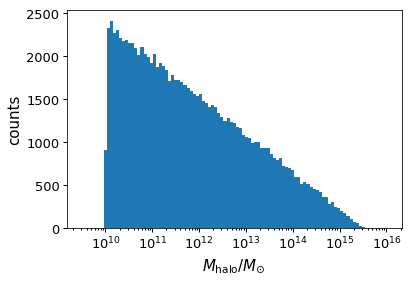

In [3]:
from scipy.stats import powerlaw

#  First generate a power law variable distributed across the unit interval
uran = np.random.rand(num_halos)
index = 2
y = powerlaw.isf(1-uran, index)

#  Now rescale the variable to span the typical range of host halo masses
log_mhalo_min, log_mhalo_max = 10, 15.5
dlog_mhalo = log_mhalo_max - log_mhalo_min
galaxies['host_halo_mass'] = 10**(log_mhalo_max - dlog_mhalo*y)

#  Inspect the results
fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')
log_mhalo_bins = np.logspace(9.5, 16, 100)
__=ax.hist(galaxies['host_halo_mass'], bins=log_mhalo_bins)
xlabel = ax.set_xlabel(r'$M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'counts')


Use a Conditional Luminosity Function in Halotools to map halo mass to central galaxy luminosity

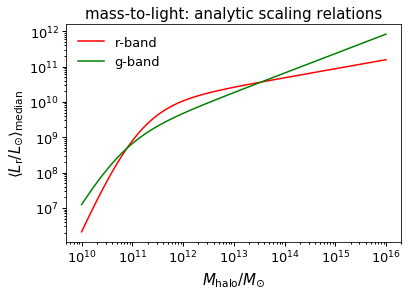

In [4]:
from halotools.empirical_models import Cacciato09Cens
clf_model = Cacciato09Cens()

m = np.logspace(10, 16, 100)

#  Set parameters for the r-band relation (these are just toy values)
clf_model.param_dict['gamma_1'] = 3.273
clf_model.param_dict['log_L_0'] = 9.935
clf_model.param_dict['log_M_1'] = 11.07
clf_model.param_dict['gamma_2'] = 0.255

median_lr_table = clf_model.median_prim_galprop(prim_haloprop=m)

#  Store the parameter dictionary for later use
from copy import deepcopy
rband_dict = deepcopy(clf_model.param_dict)

#  Set parameters for the g-band relation (these are just toy values)
clf_model.param_dict['gamma_1'] = 2.5
clf_model.param_dict['log_L_0'] = 9.
clf_model.param_dict['log_M_1'] = 10.7
clf_model.param_dict['gamma_2'] = 0.55

median_lg_table = clf_model.median_prim_galprop(prim_haloprop=m)

#  Store the parameter dictionary for later use
gband_dict = deepcopy(clf_model.param_dict)

#  Visually inspect the results
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.plot(m, median_lr_table, label='r-band', color='red')
__=ax.plot(m, median_lg_table, label='g-band', color='green')

xlabel = ax.set_xlabel(r'$M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\langle L_{\rm r} / L_{\odot}\rangle_{\rm median}$')
title = ax.set_title(r'mass-to-light: analytic scaling relations')
legend = ax.legend()

figname = 'analytic_mass_to_light_g_r_bands.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

Use scipy to generate correlated Gaussian randoms according to an input covariance matrix

In [5]:
#  Set up the (toy) covariance matrix
cov = np.array(((0.03, 0.05), (0.05, 0.1)))

#  Calculate the eigenvectors of Cov 
from scipy.linalg import eigh
evals, evecs = eigh(cov)

#  Define a transformation matrix U so that U*U^T = cov
U = np.dot(evecs, np.diag(np.sqrt(evals)))

#  Draw Gaussian randoms with mean=0 and std=1 for two independent variables: (a, b)
from scipy.stats import norm
a = norm.rvs(size=num_halos)
b = norm.rvs(size=num_halos)
X = np.array((a, b)).reshape((2, num_halos))

#  Use the transformation matrix U to calculate correlated variables (c, d)
Y = np.dot(U, X)
c, d = Y[0, :], Y[1, :]

Logarithmically add the Gaussian noise to the desired medians

In [6]:
#  Compute the desired medians at each halo mass

#  Update the model dictionary and compute the median
clf_model.param_dict.update(rband_dict)
median_lg = clf_model.median_prim_galprop(prim_haloprop=galaxies['host_halo_mass'])

#  Update the model dictionary and compute the median
clf_model.param_dict.update(gband_dict)
median_lr = clf_model.median_prim_galprop(prim_haloprop=galaxies['host_halo_mass'])

#  Logarithmically add Gaussian noise
log_median_r_and_g = np.log10(np.array((median_lr, median_lg)).reshape((2, num_halos)))

log_mc_r_and_g = log_median_r_and_g + Y

mc_r = 10**log_mc_r_and_g[0, :]
mc_g = 10**log_mc_r_and_g[1, :]

Plot the results

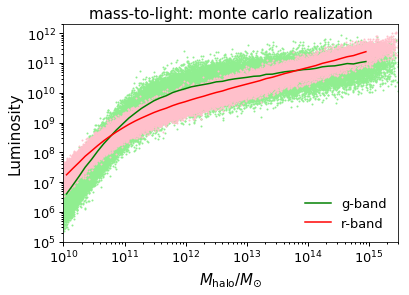

In [9]:
fig, ax = plt.subplots(1, 1)

logm = np.log10(galaxies['host_halo_mass'])

from scipy.stats import binned_statistic
logm_bins = np.linspace(10, 15, 50)
logm_mids = 0.5*(logm_bins[:-1] + logm_bins[1:])
median_rband, __, __ = binned_statistic(logm, mc_r, bins=logm_bins)
median_gband, __, __ = binned_statistic(logm, mc_g, bins=logm_bins)

__=ax.loglog()
__=ax.plot(10**logm_mids, median_gband, color='green', label='g-band')
__=ax.plot(10**logm_mids, median_rband, color='red', label='r-band')

__=ax.scatter(10**logm, mc_g, s=1, color='lightgreen')
__=ax.scatter(10**logm, mc_r, s=1, color='pink')

xlim = ax.set_xlim(1e10, 3e15)
ylim = ax.set_ylim(1e5, 2e12)

xlabel = ax.set_xlabel(r'$M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'Luminosity')
title = ax.set_title(r'mass-to-light: monte carlo realization')
legend = ax.legend()


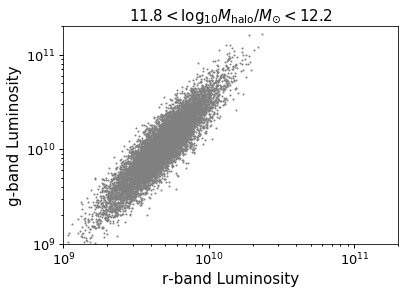

In [10]:
halo_mass_mask = (logm < 12.2) & (logm > 11.8)

fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.scatter(mc_r[halo_mass_mask], mc_g[halo_mass_mask], s=1, color='gray')

xlim = ax.set_xlim(1e9, 2e11)
ylim = ax.set_ylim(1e9, 2e11)

xlabel = ax.set_xlabel(r'r-band Luminosity')
ylabel = ax.set_ylabel(r'g-band Luminosity')
title = ax.set_title(r'$11.8 < \log_{10}M_{\rm halo}/M_{\odot} < 12.2$')

